## Libraries

In [5]:
from collections import Counter,defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pprint import pprint
import json
from bs4 import BeautifulSoup
import sys
import os
import ast
from gensim.models.doc2vec import Doc2Vec,LabeledSentence
import csv

#os.environ['KERAS_BACKEND']='theano'
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback


from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report,jaccard_similarity_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

import re

## Load-In Data/Pre-process

### Combined

In [2]:
def preprocess(article):
    article = article.encode('utf-8')
    article = str(article.lower())
    return removeTagsInterpuntion(article)

def removeTagsInterpuntion(article): #remove URL's, HTML-tags and interpuntion
    article = re.sub("<\w*>", '', article)
    article = re.sub("<\w*\s\/>", '', article)
    article = re.sub("^https?:\/\/.*[\r\n]*", '', article)
    article = re.sub('\\\\x\S.', '', article)
    article = re.sub('[^a-z\s]', '', article)
    return article

def json_readr(file):
    for line in open(file, mode="r"):
        yield json.loads(line)

def loadData(path, texts, labels, urls, highLevelLabels = True):
    with open(path) as data_file:    
        for line in data_file:
            jsons = re.split('\]\[', line)
            data = []
            for newline in jsons:
                newline = re.sub('\]\[', '\[', newline)
                if newline[0] is not "[":
                    newline = "[" + newline
                if newline[len(newline)-1] is not "}" and newline[len(newline)-1] is not "]":
                    newline+= "}"
                if newline[len(newline)-1] is not "]":
                    newline+= "]"
                betterload = json.loads(newline)
                data.extend(betterload)
    for article in data:
        text = preprocess(article["content"])
        if len(article["category"]) != 0:
            if len(text.split()) > 9 and article["category"][0] != "NOCAT": #Remove small sentences
                if article["url"] not in urls and "kv-tk" not in article["url"]:
                    urls.append(article["url"])
                    texts.append(text)
                    if highLevelLabels:
                        label = []
                        for lowLevelLabel in article["category"]:
                            if lowLevelLabel.split("|")[0] not in label:
                                label.append(lowLevelLabel.split("|")[0])
                        labels.append(label)
                    else:
                        labels.append(article["category"])
    return texts, labels, urls

In [3]:
texts = []
labels = []
urls = []
paths = [r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_jan2016.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_jan2015.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_okt2015.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_2017.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_2010-2014.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_2001-2003.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_2004-2006.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_goed_2007-2009.json"]

for path in paths:
    texts, labels, urls = loadData(path, texts, labels, urls)
    print("path done")
    
print(len(texts))
#Prepare splitting
VALIDATION_SPLIT = 0.15
TEST_SET = 0.15
indices = np.arange(len(labels))
np.random.shuffle(indices)
texts = np.array(texts)[indices]
labels = np.array(labels)[indices]
urls = np.array(urls)[indices]
nb_validation_samples = int(VALIDATION_SPLIT * labels.shape[0])
nb_test_samples = int(TEST_SET * labels.shape[0])

path done
path done
path done
path done
path done
path done
path done
path done
52397


In [6]:
# import csv
# with open('parlementData_2001-2017.csv', 'w', newline='') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter='&', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     for url, text, label in zip(urls,texts,labels):
#         spamwriter.writerow([url,text,str(label)])

### CNN

In [4]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 160

lb = MultiLabelBinarizer()
labelsCNN = lb.fit_transform(labels)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labelsCNN.shape)

x_train = data[:-nb_validation_samples-nb_test_samples]
y_train = labelsCNN[:-nb_validation_samples-nb_test_samples]
x_val = data[-nb_validation_samples-nb_test_samples:-nb_test_samples]
y_val = labelsCNN[-nb_validation_samples-nb_test_samples:-nb_test_samples]
x_test = data[-nb_test_samples:]
y_test = labelsCNN[-nb_test_samples:]

xTrain = texts[:-nb_validation_samples-nb_test_samples]
xVal = texts[-nb_validation_samples-nb_test_samples:-nb_test_samples]
xTest = texts[-nb_test_samples:]


transformer = TfidfVectorizer(smooth_idf=False, min_df=0.00001, max_df=0.2, sublinear_tf=True)
    
xTrain = transformer.fit_transform(xTrain)
xVal = transformer.transform(xVal)
xTest = transformer.transform(xTest)

print('Class distribution in training and validation set ')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Found 392519 unique tokens.
Shape of data tensor: (52397, 1000)
Shape of label tensor: (52397, 17)
Class distribution in training and validation set 
[2432 2957 5475 2854  896 5012 1501 2561 3925 2456 7155 6762 1322 1325
 3075 2409 7528]
[ 507  620 1248  587  191 1066  327  584  821  532 1552 1399  283  298
  631  518 1590]


### Baselines

In [6]:
def evaluation(yVal,yPred):
    print("Accuracy is " + str(accuracy_score(yVal, yPred)))
    print("F1 is " + str(f1_score(yVal, yPred, average="micro")))
    print("Precision is " + str(precision_score(yVal, yPred, average="micro")))
    print("Recall is " + str(recall_score(yVal, yPred, average="micro")))
    #print(confusion_matrix(yVal, yPred))



In [8]:
clf = MultinomialNB(fit_prior= False)
clf = OneVsRestClassifier(clf).fit(xTrain, y_train)
yPred = clf.predict(xTest)
evaluation(y_test,yPred)

#gridsearch
# parameters = {
#     "estimator__fit_prior": [True, False],
# }
# model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, y_train)
# print(model_tunning.best_score_)
# print(model_tunning.best_params_ )


Accuracy is 0.05814989184374603
F1 is 0.08609420779806175
Precision is 0.9744897959183674
Recall is 0.045036547983966044


### SGD

In [15]:
clf = SGDClassifier(max_iter=10, tol=None)
clf = OneVsRestClassifier(clf)    
parameters = {
    "estimator__loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
    "estimator__penalty": ["none", "l2", "l1", "elasticnet"],
    "estimator__alpha": [0.001, 0.0001,0.00001],
}
model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_ )

0.49993184110799094
{'estimator__alpha': 1e-05, 'estimator__loss': 'hinge', 'estimator__penalty': 'l2'}


In [8]:
clf = SGDClassifier(alpha = 1e-05, loss = 'modified_huber', penalty = 'l2', random_state=42, max_iter=10, tol=None)
clf = OneVsRestClassifier(clf).fit(xTrain, y_train)
yPred = clf.predict(xTest)
evaluation(y_test,yPred)

Accuracy is 0.5416719684438224
F1 is 0.7751846877098724
Precision is 0.8321167883211679
Recall is 0.7255441188025458


### Logistic Regression

In [34]:
clf = LogisticRegression(dual=False)
clf = OneVsRestClassifier(clf)

#gridsearch    
parameters = {
    "estimator__penalty": ["l1", "l2"],
    "estimator__C": [100,300,1000,3000,10000],#[0.001,0.01,0.1,1,10,100,1000],
    "estimator__solver": ["sag"], #, "newton-cg", "saga","lbfgs"],

}
model_tunning = GridSearchCV(clf, param_grid=parameters,error_score=0.0).fit(xTrain, y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_ )


C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:1686: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError('Solver sag supports only l2 penalties, got l1 penalty.',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:1686: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError('Solver sag supports only l2 penalties, got l1 penalty.',)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:1686: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError('Solver sag supports

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

0.4935794323727474
{'estimator__C': 10000, 'estimator__penalty': 'l2', 'estimator__solver': 'sag'}


C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [35]:
clf = LogisticRegression(C= 10000, penalty= 'l2', solver= 'sag',dual=False)
clf = OneVsRestClassifier(clf).fit(xTrain, y_train)
yPred = clf.predict(xTest)
evaluation(y_test,yPred)


C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

Accuracy is 0.5367095050260847
F1 is 0.7745831915617558
Precision is 0.8408902022347401
Recall is 0.717968934794607


C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Random Forest

In [46]:
# clf = RandomForestClassifier(n_estimators=30,max_depth=50)
# clf = OneVsRestClassifier(clf).fit(xTrain, y_train)
# yPred = clf.predict(xVal)
# evaluation(y_val,yPred)

clf = RandomForestClassifier()
parameters = {
    "criterion": ["entropy"],
    "max_depth": [100,300,1000,3000,10000],
    "n_estimators": [3,10,300]
}
model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_ )

0.19913301889364488
{'criterion': 'entropy', 'max_depth': 1000, 'n_estimators': 3}


In [6]:
clf = RandomForestClassifier()
clf = OneVsRestClassifier(clf)
parameters = {
    "estimator__criterion": ["entropy"],
    "estimator__max_depth": [10,30,100,300,1000],
    "estimator__n_estimators": [3,10,30]
}
model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_ )

0.24711687886801711
{'estimator__criterion': 'entropy', 'estimator__max_depth': 100, 'estimator__n_estimators': 10}


In [41]:
clf = RandomForestClassifier(criterion= 'entropy', max_depth= 100, n_estimators= 30)
clf = OneVsRestClassifier(clf).fit(xTrain, y_train)
yPred = clf.predict(xTest)
evaluation(y_test,yPred)

NameError: name 'xTrain' is not defined

In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1_micro")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\PC-Axel\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

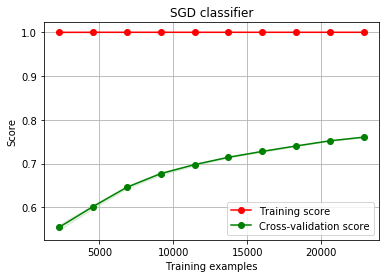

In [30]:
clf = SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-5, max_iter=10, tol=None)
clf = OneVsRestClassifier(clf)

allTexts = transformer.transform(texts)

plot_learning_curve(clf, "SGD classifier", allTexts, np.concatenate((y_train,y_val)))

<module 'matplotlib.pyplot' from 'C:\\Users\\PC-Axel\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

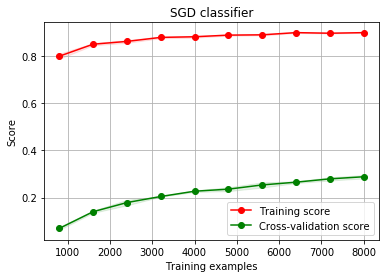

In [28]:
clf = RandomForestClassifier()
clf = OneVsRestClassifier(clf)

allTexts = transformer.transform(texts)

plot_learning_curve(clf, "SGD classifier", allTexts, np.concatenate((y_train,y_val)))

<module 'matplotlib.pyplot' from 'C:\\Users\\PC-Axel\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

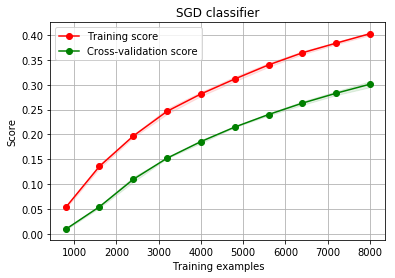

In [29]:
clf = LogisticRegression(dual=False)
clf = OneVsRestClassifier(clf)

allTexts = transformer.transform(texts)

plot_learning_curve(clf, "SGD classifier", allTexts, np.concatenate((y_train,y_val)))

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

<module 'matplotlib.pyplot' from 'C:\\Users\\PC-Axel\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

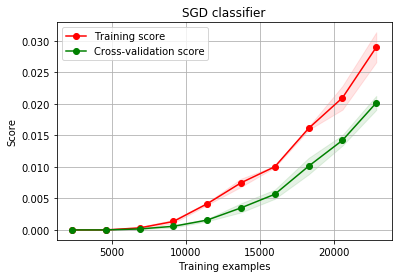

In [33]:
clf = MultinomialNB()
clf = OneVsRestClassifier(clf)

allTexts = transformer.transform(texts)

plot_learning_curve(clf, "SGD classifier", allTexts, np.concatenate((y_train,y_val)))

## Train Models and evaluate

In [53]:
GLOVE_DIR = r"C:\Users\PC-Axel\Documents\Codeer projecten\Word2Vec Vectoren\Nederlandse word2vec\combined-160.txt"
#GLOVE_DIR = r"C:\Users\PC-Axel\Documents\GitHub\thesis\Code\Data preparation\zelfgemaakte-w2v.txt"
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 1442951 word vectors in Glove 6B 100d.


In [52]:
import keras.backend as K

def fmeasure(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())

    beta = 1 # fmeasure
    bb = beta**2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

import keras.objectives
keras.objectives.fmeasure = fmeasure

### CNN

In [10]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_drop = Dropout(0.5)(l_flat)
l_dense = Dense(128, activation='relu')(l_drop)
preds = Dense(labelsCNN.shape[1], activation='sigmoid')(l_dense)

modelCNN = Model(sequence_input, preds)
modelCNN.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[keras.metrics.categorical_accuracy, fmeasure])
filepath="best-model-CNN-adaptedW2V"
checkpoint = ModelCheckpoint(filepath, monitor="val_fmeasure", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [15]:
print("modelCNN fitting - simplified convolutional neural network")
modelCNN.summary()
historyCNN = modelCNN.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=7, batch_size=128, callbacks=callbacks_list)

modelCNN fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 160)         62803200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          102528    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)

In [12]:
prediction = modelCNN.predict(x_test)

In [13]:
evaluation(y_test, (prediction > 0.3).astype(int))
print()
evaluation(y_test, (prediction > 0.4).astype(int))
print()
evaluation(y_test, (prediction > 0.5).astype(int))
print()
evaluation(y_test, (prediction > 0.6).astype(int))
print()
evaluation(y_test, (prediction > 0.99).astype(int))

Accuracy is 0.30907240106883827
F1 is 0.6575788691003082
Precision is 0.5985175636480825
Recall is 0.7295725958516657

Accuracy is 0.3614963735844255
F1 is 0.6684555283718727
Precision is 0.6714761376248612
Recall is 0.6654619736015085

Accuracy is 0.3864359333248505
F1 is 0.660189165950129
Precision is 0.7290163311811622
Recall is 0.6032369578881207

Accuracy is 0.3873266318870085
F1 is 0.6367863120699274
Precision is 0.7799544419134397
Recall is 0.5380263984915148

Accuracy is 0.10319379055859525
F1 is 0.14486219184059343
Precision is 0.9736070381231672
Recall is 0.0782526712759271


### CNN plus

In [28]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# applying a more complex convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=128,kernel_size=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)

l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_drop = Dropout(0.5)(l_flat)
l_dense = Dense(128, activation='relu')(l_drop)
preds = Dense(labelsCNN.shape[1], activation='sigmoid')(l_dense)

modelCNNPlus = Model(sequence_input, preds)
modelCNNPlus.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[keras.metrics.categorical_accuracy, fmeasure])

filepath="best-model-CNNplus"
checkpoint = ModelCheckpoint(filepath, monitor="val_fmeasure", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [32]:
print("modelCNNPlus fitting - more complex convolutional neural network")
modelCNNPlus.summary()
historyCNNPlus = modelCNNPlus.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128, callbacks=callbacks_list)

modelCNNPlus fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1000, 160)    62803200    input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 998, 128)     61568       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 997, 128)     82048       embedding_6[0][0]                
____________________________________________

KeyboardInterrupt: 

In [33]:
prediction = modelCNNPlus.predict(x_test)

In [34]:
evaluation(y_test, (prediction > 0.3).astype(int))
print()
evaluation(y_test, (prediction > 0.4).astype(int))
print()
evaluation(y_test, (prediction > 0.5).astype(int))
print()
evaluation(y_test, (prediction > 0.6).astype(int))
print()
evaluation(y_test, (prediction > 0.99).astype(int))

Accuracy is 0.41010306654790685
F1 is 0.7255347201875183
Precision is 0.6829150579150579
Recall is 0.773828125

Accuracy is 0.43415192772617384
F1 is 0.7321955896452541
Precision is 0.7190960451977401
Recall is 0.74578125

Accuracy is 0.4554014505662298
F1 is 0.7350810486291774
Precision is 0.7536315141567501
Recall is 0.717421875

Accuracy is 0.4589642448148619
F1 is 0.7293931442375776
Precision is 0.7811579980372915
Recall is 0.6840625

Accuracy is 0.30512787886499554
F1 is 0.47843775427176555
Precision is 0.9341806627326373
Recall is 0.3215625


In [37]:
modelCNN.save('models/CNN-Model-17-1')  # creates a HDF5 file 'my_model.h5'
with open('models/CNN-Model-17-1-History', 'wb') as file_pi:
    pickle.dump(historyCNN.history, file_pi)
    
modelCNNPlus.save('models/CNNPlus-Model-17-1')  # creates a HDF5 file 'my_model.h5'
with open('models/CNNPlus-Model-17-1-History', 'wb') as file_pi:
    pickle.dump(historyCNNPlus.history, file_pi)

### Split up

In [5]:
##### Try splitting in parts of 200
newTexts = []
newLabels = []
newUrls = []
i = 0 
for text, label, url in zip(texts,labels, urls):
    chunks = [text.split()[x:x+200] for x in range(0, len(text.split()), 200)]
    newTexts.extend(chunks)
    newLabels.extend([label]*len(chunks))
    newUrls.extend([url]*len(chunks))
    i += 1
    if i > nb_validation_samples:
        new_nb_validation_samples = i

lb = MultiLabelBinarizer()
labelsCNN = lb.fit_transform(newLabels)

MAX_SEQUENCE_LENGTH = 200
MAX_NB_WORDS = 80000
EMBEDDING_DIM = 160


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(newTexts)
sequences = tokenizer.texts_to_sequences(newTexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labelsCNN.shape)

x_train = data[:-new_nb_validation_samples]
y_train = labelsCNN[:-new_nb_validation_samples]
x_val = data[-new_nb_validation_samples:]
y_val = labelsCNN[-new_nb_validation_samples:]


print('Class distribution in training and validation set ')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Found 392519 unique tokens.
Shape of data tensor: (206668, 200)
Shape of label tensor: (206668, 17)
Class distribution in training and validation set 
[ 9442 11054 24953 12699  3890 19516  6353  9934 17263 10771 27475 26326
  5413  6054 13248 10502 33884]
[ 3312  3749  8123  4097  1374  6948  2171  3396  5836  3802  9247  8758
  1899  1990  4339  3442 11663]


### Split up CNN 

In [9]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(3)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_drop = Dropout(0.5)(l_flat)
l_dense = Dense(128, activation='relu')(l_drop)
preds = Dense(labelsCNN.shape[1], activation='sigmoid')(l_dense)

modelCNN = Model(sequence_input, preds)
modelCNN.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
               metrics=[keras.metrics.categorical_accuracy, fmeasure])
filepath="best-model-CNN-splitup"
checkpoint = ModelCheckpoint(filepath, monitor="val_fmeasure", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [10]:
print("modelCNN fitting - simplified convolutional neural network")
modelCNN.summary()
historyCNN = modelCNN.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128,callbacks=callbacks_list)
#modelCNN.save('models/CNN-splitup-Model-17')  # creates a HDF5 file 'my_model.h5'
#with open('models/CNN-splitup-Model-17-History', 'wb') as file_pi:
#    pickle.dump(historyCNN.history, file_pi)

modelCNN fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 160)          62803200  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 128)          102528    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_6 (Conv1D)

In [57]:
oldModelCNN= keras.models.load_model("best-model-CNN-splitup", custom_objects={'fmeasure': fmeasure})

In [58]:
#modelCNN= keras.models.load_model("best-model-CNN-splitup")
currenturl = "a"
allPredictions,allYs = [],[]
i = False

for x,y,url in zip(x_val,y_val,newUrls[-new_nb_validation_samples:]):
    if url == currenturl:
        currentx = np.append(currentx,[x],axis=0)
    else:
        allYs.append(list(y))
        if i is True:
            prediction = modelCNN.predict(currentx)
            allPredictions.append(list((np.mean(prediction, axis=0) > 0.5).astype(int)))
        currentx = np.array([x])
        currenturl = url
        i = True

prediction = modelCNN.predict(currentx)
allPredictions.append(list((np.mean(prediction, axis=0) > 0.5).astype(int)))

In [59]:
evaluation(np.array(allYs),np.array(allPredictions))

F1 is 0.7320129636298164
Precision is 0.7556877323420075
Recall is 0.7097765363128492


### Splitup ccn plus

In [10]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# applying a more complex convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=128,kernel_size=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)

l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(3)(l_cov2)
l_flat = Flatten()(l_pool2)
l_drop = Dropout(0.5)(l_flat)
l_dense = Dense(128, activation='relu')(l_drop)
preds = Dense(labelsCNN.shape[1], activation='sigmoid')(l_dense)

modelCNNPlus = Model(sequence_input, preds)
modelCNNPlus.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[keras.metrics.categorical_accuracy, fmeasure])

filepath="best-model-CNNplus-splitup"
checkpoint = ModelCheckpoint(filepath, monitor="val_fmeasure", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [12]:
print("modelCNN fitting - simplified convolutional neural network")
modelCNNPlus.summary()
historyCNNPlus = modelCNNPlus.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128,callbacks=callbacks_list)
#modelCNN.save('models/CNN-splitup-Model-17')  # creates a HDF5 file 'my_model.h5'
#with open('models/CNN-splitup-Model-17-History', 'wb') as file_pi:
#    pickle.dump(historyCNN.history, file_pi)

modelCNN fitting - simplified convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 160)     62803200    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 198, 128)     61568       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 197, 128)     82048       embedding_2[0][0]                
__________________________________________________

In [13]:
oldModelCNN= keras.models.load_model("best-model-CNNplus-splitup", custom_objects={'fmeasure': fmeasure})

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [15]:
#modelCNN= keras.models.load_model("best-model-CNN-splitup")
currenturl = "a"
allPredictions,allYs = [],[]
i = False

for x,y,url in zip(x_val,y_val,newUrls[-new_nb_validation_samples:]):
    if url == currenturl:
        currentx = np.append(currentx,[x],axis=0)
    else:
        allYs.append(list(y))
        if i is True:
            prediction = oldModelCNN.predict(currentx)
            allPredictions.append(list((np.mean(prediction, axis=0) > 0.5).astype(int)))
        currentx = np.array([x])
        currenturl = url
        i = True

prediction = oldModelCNN.predict(currentx)
allPredictions.append(list((np.mean(prediction, axis=0) > 0.5).astype(int)))

NameError: name 'modelCNN' is not defined

In [16]:
evaluation(np.array(allYs),np.array(allPredictions))

F1 is 0.7418708352121849
Precision is 0.804247460757156
Recall is 0.6884735202492211


## Evaluate Models

In [10]:
import csv
textsTest = []
labelsTest = []

with open(r"C:\Users\PC-Axel\Documents\GitHub\thesis\Code\Data preparation\filteredGemeentes.csv", 'r') as csvfile:
    next(csvfile)
    spamreader = csv.reader(csvfile, delimiter=';')
    
    for row in spamreader:
        if len(row) > 4:
            if len(row[4]) > 0: 
                if row[4][0] is "[":
                    textsTest.append(preprocess(row[1]))
                    labelTest = ast.literal_eval(row[4].lower())
                    newlabelTest = []
                    for lab in labelTest:
                        lab += " "
                        lab = lab[0].upper() + lab[1:]
                        if "e"  in lab or "a" in lab:
                            newlabelTest.append(lab)     
                    labelsTest.append(newlabelTest)

with open(r"C:\Users\PC-Axel\Documents\GitHub\thesis\Code\Data preparation\alleGemeentes2.csv", 'r') as csvfile:
    next(csvfile)
    spamreader = csv.reader(csvfile, delimiter='|')
    
    for row in spamreader:
        if len(row) > 4:
            if len(row[4]) > 0: 
                if row[4][0] is "[":
                    textsTest.append(preprocess(row[1]))
                    labelTest = ast.literal_eval(row[4])
                    newlabelTest = []
                    for lab in labelTest:
                        if "Finan" in lab:
                            lab = "Financiën "
                        if "e"  in lab or "a" in lab:
                            newlabelTest.append(lab)     
                    labelsTest.append(newlabelTest)

with open('municipality.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter='&', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for url, text, label in zip(range(len(textsTest)),textsTest,labelsTest):
        spamwriter.writerow([url,text,str(label)])                    

labelsTest = lb.transform(labelsTest)

textsTest = transformer.transform(textsTest)

In [14]:
# clf = SGDClassifier(alpha = 1e-05, loss = 'hinge', penalty = 'l2', random_state=42, max_iter=10, tol=None)
# clf = OneVsRestClassifier(clf).fit(xTrain, y_train)
# prediction = clf.predict(textsTest)
# evaluation(labelsTest,prediction)

clf = MultinomialNB(fit_prior= False)
clf = OneVsRestClassifier(clf).fit(xTrain, y_train)
prediction = clf.predict_proba(textsTest)
for threshold in [.1,.2,.25,.3,.4,.5,.6,.9]:
    realPrediction = (np.array(prediction) > threshold).astype(int)
    evaluation(labelsTest,realPrediction)
    print()

Accuracy is 0.10052910052910052
F1 is 0.02937576499388005
Precision is 0.01854714064914992
Recall is 0.07058823529411765

Accuracy is 0.164021164021164
F1 is 0.036832412523020254
Precision is 0.02680965147453083
Recall is 0.058823529411764705

Accuracy is 0.19576719576719576
F1 is 0.030042918454935622
Precision is 0.02364864864864865
Recall is 0.041176470588235294

Accuracy is 0.2222222222222222
F1 is 0.02985074626865672
Precision is 0.02586206896551724
Recall is 0.03529411764705882

Accuracy is 0.26455026455026454
F1 is 0.025157232704402514
Precision is 0.02702702702702703
Recall is 0.023529411764705882

Accuracy is 0.31746031746031744
F1 is 0.018867924528301886
Precision is 0.047619047619047616
Recall is 0.011764705882352941

Accuracy is 0.3439153439153439
F1 is 0.0
Precision is 0.0
Recall is 0.0

Accuracy is 0.35978835978835977
F1 is 0.0
Precision is 0.0
Recall is 0.0



C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
textsTest = []
labelsTest = []

with open(r"C:\Users\PC-Axel\Documents\GitHub\thesis\Code\Data preparation\filteredGemeentes.csv", 'r') as csvfile:
    next(csvfile)
    spamreader = csv.reader(csvfile, delimiter=';')
    
    for row in spamreader:
        if len(row) > 4:
            if len(row[4]) > 0: 
                if row[4][0] is "[":
                    textsTest.append(preprocess(row[1]))
                    labelTest = ast.literal_eval(row[4].lower())
                    newlabelTest = []
                    for lab in labelTest:
                        lab += " "
                        lab = lab[0].upper() + lab[1:]
                        if "e"  in lab or "a" in lab:
                            newlabelTest.append(lab)     
                    labelsTest.append(newlabelTest)

with open(r"C:\Users\PC-Axel\Documents\GitHub\thesis\Code\Data preparation\alleGemeentes2.csv", 'r') as csvfile:
    next(csvfile)
    spamreader = csv.reader(csvfile, delimiter='|')
    
    for row in spamreader:
        if len(row) > 4:
            if len(row[4]) > 0: 
                if row[4][0] is "[":
                    textsTest.append(preprocess(row[1]))
                    labelTest = ast.literal_eval(row[4])
                    newlabelTest = []
                    for lab in labelTest:
                        if "Finan" in lab:
                            lab = "Financiën "
                        if "e"  in lab or "a" in lab:
                            newlabelTest.append(lab)     
                    labelsTest.append(newlabelTest)
labelsTest = lb.transform(labelsTest)


In [56]:
import csv


oldModelCNN= keras.models.load_model("best-model-CNNPlus", custom_objects={'fmeasure': fmeasure})
#oldModelCNN = modelCNN

                 
                    
sequencesTest =tokenizer.texts_to_sequences(np.array(textsTest))
dataTest = pad_sequences(sequencesTest, maxlen=MAX_SEQUENCE_LENGTH)
prediction = oldModelCNN.predict(dataTest)

for threshold in [.2,.25,.3,.35,.4,.45,.5,.6,.7,.8,.9]:
    realPrediction = (np.array(prediction) > threshold).astype(int)
    evaluation(labelsTest,realPrediction)
    print()

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


Accuracy is 0.015873015873015872
F1 is 0.10593490746649649
Precision is 0.05941302791696493
Recall is 0.48823529411764705

Accuracy is 0.026455026455026454
F1 is 0.11697806661251013
Precision is 0.06786050895381715
Recall is 0.4235294117647059

Accuracy is 0.037037037037037035
F1 is 0.14857142857142855
Precision is 0.09219858156028368
Recall is 0.38235294117647056

Accuracy is 0.042328042328042326
F1 is 0.16333938294010888
Precision is 0.11811023622047244
Recall is 0.2647058823529412

Accuracy is 0.1111111111111111
F1 is 0.19047619047619047
Precision is 0.16593886462882096
Recall is 0.2235294117647059

Accuracy is 0.30687830687830686
F1 is 0.18122977346278318
Precision is 0.2014388489208633
Recall is 0.16470588235294117

Accuracy is 0.3333333333333333
F1 is 0.18050541516245489
Precision is 0.2336448598130841
Recall is 0.14705882352941177

Accuracy is 0.37037037037037035
F1 is 0.15319148936170213
Precision is 0.27692307692307694
Recall is 0.10588235294117647

Accuracy is 0.3862433862433

In [71]:
sentence = tokenizer.texts_to_sequences(np.array([preprocess('1.  Opening.   2.  Spreekrecht burgers.   3.  Vragenkwartier.   4.  Bepalen stemvolgorde.   5.  Vaststellen agenda.   6.  Voorstel tot het vaststellen van de Leegstandsverordening.  Een leegstandverordening biedt de gemeente de mogelijkheid vastgoedeigenaren van leegstaande panden in de binnenstad actief aan te spreken. Pandeigenaren worden verplicht om leegstand te melden. Vervolgens gaat de gemeente in overleg met de eigenaren over mogelijke oplossingen. Er kan een boete worden opgelegd als pandeigenaren niet meewerken. 7.  Voorstel tot het vaststellen van de Verordening Cli\xc3\xabntenparticipatie 2016.  In de Wet maatschappelijke ondersteuning, Jeugdwet en Participatiewet is geregeld dat cli\xc3\xabnten of hun vertegenwoordigers betrokken worden bij de uitvoering van de wet. De gemeente moet onder andere de wijze regelen waarop cli\xc3\xabnten vroegtijdig gevraagd en ongevraagd advies uit kunnen brengen. Bij raadsbesluit van 15 februari 2016 heeft het college van burgemeester en wethouders tevens de opdracht gekregen de bestaande wijze van cli\xc3\xabntenparticipatie om te vormen tot een moderne participatieraad. De nu voorliggende verordening dient hier toe. 8.  Voorstel met betrekking tot de jaarstukken 2015 en de begroting 2017 van de Gemeenschappelijke Regeling Gesubsidieerde Arbeid Kop van Noord-Holland.  De raad wordt gevraagd de zienswijze op de begroting 2017 van de Gemeenschappelijke Regeling Gesubsidieerde Arbeid Kop van Noord-Holland in te dienen bij het Dagelijks Bestuur van de Gemeenschappelijke Regeling Gesubsidieerde Arbeid Kop van Noord-Holland en kennis te nemen van de jaarstukken 2015. 9.  Voorstel tot het vaststellen van de deelsubsidieverordening Subsidieverlening sportverenigingen.  Tijdens de behandeling van de evaluatie van het sportbesluit is besloten om naast het continueren van het sportbesluit (tarieven en subsidies) ook de deelsubsidieverordening uit 2011 te continueren en in overeestemming te brengen met de uitkomsten uit de evaluatie van het sportbesluit.De voorliggende deelsubsidieverordening dient hier toe. 10.  Voorstel tot het benoemen van plaatsvervangende leden van de regionale raadscommissie Noordkop.  In de Verordening Noordkopraad i.o. 2015 is bepaald dat deze regionale raadscommissie is samengesteld uit \xc3\xa9\xc3\xa9n afgevaardigde per fractie uit de raden. De raden hebben daarom vorig jaar per fractie \xc3\xa9\xc3\xa9n afgevaardigde aangewezen. Bij het aanbieden van de stukken voor de regionale raadscommissie Noordkop van 2 juni jl. is aangekondigd dat voor deze commissie elke individuele fractie de gelegenheid moet hebben deel te nemen aan de regionale beraadslagingen. Met dit voorstel wordt daaraan tegemoet gekomen. 11.  Voorstel tot het vaststellen van de Woonvisie Den Helder 2016-2020.  Met de Woonvisie, die in samenspraak met betrokken partijen is opgesteld, wordt beoogd dat Den Helder voor de verschillende doelgroepen een stad blijft waar het prettig wonen en werken is. In de visie is aangegeven welke opgaven er liggen om dat te bereiken. Op basis van deze visie worden vervolgens prestatieafspraken gemaakt met woningbouwcorporaties. 12.  Voorstel tot het instellen van de commissie Renovatie stadhuis 2016.  Op 13 juni 2016 heeft de raad een motie aangenomen over renovatie van het stadhuis aan de Drs. F. Bijlweg 20. Daarmee is besloten een te benoemen commissie van zeven raadsleden direct te betrekken bij het opstellen van het plan en de nadere uitwerking daarvan om de controle op de voortgang en inhoud mogelijk te maken en verdere vertraging te voorkomen. De commissie bewaakt de geformuleerde uitgangspunten voor de renovatie en kan desgewenst actie ondernemen naar het college van burgemeester en wethouders of de gemeenteraad. De start van de renovatie is medio 2017 voorzien. 13.  Voorstel tot het vaststellen van de jaarrekening 2015 van de gemeente Den Helder.  Het college van burgemeester en wethouders heeft de jaarrekening 2015 van de gemeente ter vaststelling aan de gemeenteraad aangeboden. Voorgesteld wordt het voordelig rekeningresultaat, ad \xe2\x82\xac 12,5 mln. te storten in de algemene reserve en vervolgens een bedrag van \xe2\x82\xac 11,5 mln. te onttrekken aan de algemene reserve en dit bedrag nader te bestemmen.  Het verslag van bevindingen en de goedkeurende controleverklaring van de accountant (EY) worden respectievelijk uiterlijk op 27 juni en 11 juli 2016 verwacht. Het advies van de auditcommissie wordt uiterlijk dinsdag 28 juni aan de stukken toegevoegd. 14.  Voorstel tot het vaststellen van de spelregels voor de bestemmingsreserve sociaal domein.  Bij het vaststellen van de programmabegroting 2016 heeft de raad besloten een bestemmingsreserve sociaal domein in te stellen en eventuele incidentele meevallers in deze reserve te storten. Ingevolge dit besluit heeft het college van burgemeester en wethouders bij de aanbieding van de jaarrekening 2015 voorgesteld een bedrag van \xe2\x82\xac 8 mln. toe te voegen aan deze bestemmingsreserve. Thans stelt het college een aantal spelregels voor ten aanzien van de bestemmingsreserve sociaal domein. 15.  Motie verkeersveiligheid kruispunt Ruyghweg/Fabriekgracht.  De fractie van Behoorlijk Bestuur dient een motie in waarmee het college van burgemeester en wethouders wordt opgedragen zo snel mogelijk doch uiterlijk 1 september 2016 in goed overleg met vertegenwoordigers van VVN, Fietsersbond Den Helder en omwonenden maatregelen te treffen op en rond de kruising Ruyghweg/Fabrieksgracht waardoor het gevaar van verkeersongevallen in het algemeen maar in het bijzonder tussen ongemotoriseerde en gemotoriseerde verkeersdeelnemers substantieel wordt verkleind. 16.  Motie opvang gezinnen na huisuitzetting met problematische schulden.  De fracties van de ChristenUnie en Beter voor Den Helder dienen een motie in waarmee het college van burgemeester en wethouders wordt opgedragen \tte onderzoeken of ook in Den Helder het mogelijk is om gezinnen een 2e kans te geven bij \thuisuitzettingen, daarvoor overleg te plegen en afspraken te maken met alle daarvoor in aanmerking komende instanties en de raad uiterlijk 1 september 2016 te informeren over de uitkomsten van dit onderzoek en overleg. 17.  Motie gebruik van grasstenen bij aanleg van nieuwe parkeerterreinen.  De fractie van GroenLinks dient een motie in waarmee het college van burgemeester en wethouders wordt opgedragen alle nieuw aan te leggen parkeerterreinen te voorzien van grasstenen en dit ook toe te passen op tijdelijke parkeerterreinen waar nog geen verharding is aangebracht. 18.  Motie Vogelasiel.  De fractie van Vermooten dient een motie in waarmee het college van burgemeester en wethouders wordt verzocht om een incidenteel bedrag van \xe2\x82\xac 10.000,- beschikbaar te stellen aan het vogelasiel, te dekken binnen programma 1, Algemeen bestuur en middelen, waaronder dierenwelzijn valt en het college van burgemeester en wethouders wordt opgedragen onderzoek te doen om de integratie van het vogelasiel met de Helderse Vallei, waarbij de beide \tlocaties ongewijzigd blijven, mogelijk te maken, 19.  Motie energiebezuinigingspakket voor minima.  De fracties van Behoorlijk Bestuur, Beter voor Den Helder, het CDA, de ChristenUnie, D66, Vermooten, GroenLinks, Helder Onafhankelijk!, de PvdA, de Stadspartij Den Helder en de Vrije Socialisten dienen een motie in waarmee het college van burgemeester en wethouders wordt opgedragen in september 2016 een voorstel tot het beschikbaar stellen van een krediet voor het verstrekken van een energiebezuinigingspakket aan huishoudens met een minimuminkomen van 120% van de norm of lager aan de raad voor te leggen. Voor zover de financi\xc3\xable consequenties niet kunnen worden opgevangen binnen het programma Sociaal Domein kunnen deze worden gedekt uit de algemene reserve. 20.  Sluiting.  ')]))
print(len(sentence[0]))
sentence = pad_sequences(sentence, maxlen=MAX_SEQUENCE_LENGTH)
predictionSentence = oldModelCNN.predict(sentence)
print(predictionSentence[0])
print(list(lb.classes_))

986
[8.3540946e-01 2.3811612e-02 1.0961948e-01 9.9531353e-02 4.4713891e-04
 3.4486495e-02 6.0074072e-04 1.7108374e-03 2.5516755e-03 1.3232090e-04
 2.1483541e-02 1.4896060e-02 1.1810069e-03 7.2888479e-02 1.3239319e-03
 4.5073792e-01 2.1663443e-03]
['Bestuur ', 'Cultuur en recreatie ', 'Economie ', 'Financiën ', 'Huisvesting ', 'Internationaal ', 'Landbouw ', 'Migratie en integratie ', 'Natuur en milieu ', 'Onderwijs en wetenschap ', 'Openbare orde en veiligheid ', 'Recht ', 'Ruimte en infrastructuur ', 'Sociale zekerheid ', 'Verkeer ', 'Werk ', 'Zorg en gezondheid ']


In [80]:
pkl_file = open('models/CNN-Model-118-History', 'rb')
historyCNN = pickle.load(pkl_file)

In [45]:
print(historyCNNPlus)

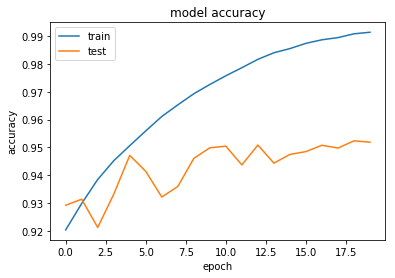

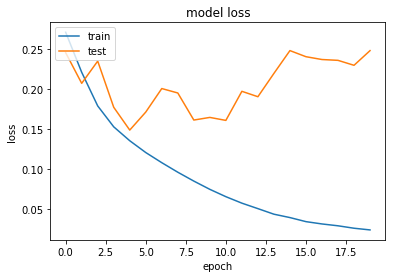

In [48]:
import matplotlib.pyplot as plt
plt.plot(historyCNNPlus.history['acc'])
plt.plot(historyCNNPlus.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyCNNPlus.history['loss'])
plt.plot(historyCNNPlus.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Par2Vec

In [49]:
corpus = []
for text, label in zip(texts[:-nb_validation_samples-nb_test_samples], labels):
    corpus.append(LabeledSentence(words=text.split(), tags=label))

model = Doc2Vec(corpus, size=300, window=8, min_count=5, workers=4)

X = []
for i in range(len(texts)):
    X.append(model.infer_vector(texts[i].split()))
X = np.asarray(X)

x_train = X[:-nb_validation_samples-nb_test_samples]
x_val = X[-nb_validation_samples-nb_test_samples:-nb_test_samples]
x_test = X[-nb_test_samples:]

lb = MultiLabelBinarizer()
labelsBin = lb.fit_transform(labels)

y_train = labelsBin[:-nb_validation_samples-nb_test_samples]
y_val = labelsBin[-nb_validation_samples-nb_test_samples:-nb_test_samples]
y_test = labelsBin[-nb_test_samples:]

clf = LogisticRegression(C= 10000, penalty= 'l2', solver= 'sag',dual=False)
clf = OneVsRestClassifier(clf).fit(x_train, y_train)
yPred = clf.predict(x_val)
evaluation(y_val,yPred)

clf = SGDClassifier(alpha = 1e-05, loss = 'hinge', penalty = 'l2', random_state=42, max_iter=10, tol=None)
clf = OneVsRestClassifier(clf).fit(x_train, y_train)
yPred = clf.predict(x_val)
evaluation(y_val,yPred)

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means

Accuracy is 0.3793103448275862
F1 is 0.6603698636183077
Precision is 0.7497494487873322
Recall is 0.5900307595236217
Accuracy is 0.3155617763074183
F1 is 0.6134400136187599
Precision is 0.6662044740247736
Recall is 0.568420222415017


In [50]:
# XTEST = []
# for i in range(len(textsTest)):
#     XTEST.append(model.infer_vector(textsTest[i].split()))
# XTEST = np.asarray(XTEST)

clf = LogisticRegression(C= 10000, penalty= 'l2', solver= 'sag',dual=False)
clf = OneVsRestClassifier(clf).fit(x_train, y_train)
yPred = clf.predict(XTEST)
evaluation(labelsTest,yPred)

clf = SGDClassifier(alpha = 1e-05, loss = 'hinge', penalty = 'l2', random_state=42, max_iter=10, tol=None)
clf = OneVsRestClassifier(clf).fit(x_train, y_train)
yPred = clf.predict(XTEST)
evaluation(labelsTest,yPred)

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

Accuracy is 0.35714285714285715
F1 is 0.0925925925925926
Precision is 0.21739130434782608
Recall is 0.058823529411764705
Accuracy is 0.3386243386243386
F1 is 0.14408233276157803
Precision is 0.1728395061728395
Recall is 0.12352941176470589


In [51]:
clf = SGDClassifier(alpha = 1e-05, loss = 'modified_huber', penalty = 'l2', random_state=42, max_iter=100, tol=None)
clf = OneVsRestClassifier(clf).fit(x_train, y_train)
prediction = clf.predict_proba(XTEST)
for threshold in [.0001,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.6,.7,.8,.9]:
    realPrediction = (np.array(prediction) > threshold).astype(int)
    evaluation(labelsTest,realPrediction)
    print()
    
print("---------------------")
clf = LogisticRegression(C= 10000, penalty= 'l2', solver= 'sag',dual=False)
clf = OneVsRestClassifier(clf).fit(x_train, y_train)
prediction = clf.predict_proba(XTEST)
for threshold in [.0001,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.6,.7,.8,.9]:
    realPrediction = (np.array(prediction) > threshold).astype(int)
    evaluation(labelsTest,realPrediction)
    print()

Accuracy is 0.25396825396825395
F1 is 0.16893203883495145
Precision is 0.12608695652173912
Recall is 0.25588235294117645

Accuracy is 0.25925925925925924
F1 is 0.16515609264853978
Precision is 0.12557427258805512
Recall is 0.2411764705882353

Accuracy is 0.26455026455026454
F1 is 0.16266944734098018
Precision is 0.1260096930533118
Recall is 0.22941176470588234

Accuracy is 0.2698412698412698
F1 is 0.16414686825053995
Precision is 0.1296928327645051
Recall is 0.2235294117647059

Accuracy is 0.2751322751322751
F1 is 0.15990990990990991
Precision is 0.12956204379562045
Recall is 0.2088235294117647

Accuracy is 0.2777777777777778
F1 is 0.15990730011587484
Precision is 0.13193116634799235
Recall is 0.20294117647058824

Accuracy is 0.291005291005291
F1 is 0.15770609318996417
Precision is 0.13279678068410464
Recall is 0.19411764705882353

Accuracy is 0.29365079365079366
F1 is 0.1589242053789731
Precision is 0.13598326359832635
Recall is 0.19117647058823528

Accuracy is 0.30158730158730157
F1 

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anacond

Accuracy is 0.0
F1 is 0.09992587101556709
Precision is 0.052615144418423104
Recall is 0.9911764705882353

Accuracy is 0.0
F1 is 0.12348248352410683
Precision is 0.06999606763664963
Recall is 0.5235294117647059

Accuracy is 0.03439153439153439
F1 is 0.15522771007055805
Precision is 0.0992616899097621
Recall is 0.3558823529411765

Accuracy is 0.2222222222222222
F1 is 0.16550348953140578
Precision is 0.12518853695324283
Recall is 0.24411764705882352

Accuracy is 0.2962962962962963
F1 is 0.15521628498727738
Precision is 0.1367713004484305
Recall is 0.17941176470588235

Accuracy is 0.3333333333333333
F1 is 0.15313935681470137
Precision is 0.1597444089456869
Recall is 0.14705882352941177

Accuracy is 0.34656084656084657
F1 is 0.13793103448275862
Precision is 0.16666666666666666
Recall is 0.11764705882352941

Accuracy is 0.3544973544973545
F1 is 0.1149425287356322
Precision is 0.16483516483516483
Recall is 0.08823529411764706

Accuracy is 0.3544973544973545
F1 is 0.10416666666666667
Precision

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
def propertiesMisclassified(yVal,xVal,yPred):    
    misclassified = []
    for y1, y2, i in zip(yVal,yPred,range(len(yPred))):
        if np.array_equal(y1,y2):
            misclassified.append(i)
    print(misclassified)
    #print(yVal)
    #print(yPred)
    #print(np.logical_and(*np.equal(yVal,yPred)))
    #misclassified = np.where(np.logical_and(np.equal(yVal,yPred)))
    #print(misclassified)
    lengthMisclassified = sum([len(doc) for doc in list(np.asarray(xVal)[misclassified])]) / len(list(np.asarray(xVal)[misclassified]))
    lengthAvg = sum([len(doc) for doc in xVal]) / len(xVal)
    print("lengthMisclassified: " + str(lengthMisclassified) + ", lengthAvg: " + str(lengthAvg))
    #return misclassified
    

In [41]:
textsTest = []
labelsTest = []

with open(r"C:\Users\PC-Axel\Documents\GitHub\thesis\Code\Model training\Familie helpt1.csv", 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    
    for row in spamreader:
        textsTest.append(preprocess(row[0]))
        labelTest = ast.literal_eval(row[1].lower())
        newlabelTest = []
        for lab in labelTest:
            
            if "inan" in lab or "cien" in lab:
                newlabelTest.append("Financiën ")
            if "uimte" in lab or "infra" in lab:
                newlabelTest.append("Ruimte en infrastructuur ")
            if "erkee" in lab:
                newlabelTest.append("Verkeer ")
            if "andbou" in lab:
                newlabelTest.append("Landbouw ")
            if "atuur en mi" in lab:
                newlabelTest.append("Natuur en milieu ")

            if "ernati" in lab:
                newlabelTest.append("Internationaal ")
            if "ondhei" in lab:
                newlabelTest.append("Zorg en gezondheid ")
            if "eilighei" in lab or "penbare orde" in lab:
                newlabelTest.append("Openbare orde en veiligheid ")
            if "recht" in lab:
                newlabelTest.append("Recht ")
            if "conomi" in lab:
                newlabelTest.append("Economie ")
                
            if "recre" in lab or "ultuur" in lab:
                newlabelTest.append("Cultuur en recreatie ")
            if "gratie" in lab:
                newlabelTest.append("Migratie en integratie ")
            if "nderwijs" in lab:
                newlabelTest.append("Onderwijs en wetenschap ")
            if "estuur" in lab:
                newlabelTest.append("Bestuur ")
            if "werk" in lab:
                newlabelTest.append("Werk ")
                
            if "uisves" in lab:
                newlabelTest.append("Huisvesting ")
            if "ociale ze" in lab:
                newlabelTest.append("Sociale zekerheid ")
        if len(labelTest) is not len(newlabelTest): print(labelTest, newlabelTest)
        labelsTest.append(newlabelTest)

with open('municipalityFam.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter='&', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for url, text, label in zip(range(len(textsTest)),textsTest,labelsTest):
        spamwriter.writerow([url,text,str(label)])           

labelsTest = lb.transform(labelsTest)

In [40]:
print(labelsTest)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
